# Regression Models

## Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from yellowbrick.regressor import PredictionError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split
from sklearn.model_selection import KFold

import pickle
from sklearn.utils import check_X_y
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel

Importing Jupyter notebook from TrainTestEvalSplit.ipynb


## Import File

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,Nieuwmarkt Lat,Nieuwmarkt Lon,Nieuwezijds Kolk Lat,Nieuwezijds Kolk Lon,Dam Lat,Dam Lon,Spui Lat,Spui Lon,...,Nieuwmarkt score,Nieuwmarkt weight,Nieuwezijds Kolk score,Nieuwezijds Kolk weight,Dam score,Dam weight,Spui score,Spui weight,Centraal Station score,Centraal Station weight
0,2018-01-01,100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,-928.658709,-2.645751,-71.435285,-2.645751,-0.000000,-2.645751,-0.000000,-2.645751,-5193.609816,-2.645751
1,2018-01-01,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,-1108.569798,-2.645751,-627.043060,-2.645751,-3529.432244,-2.645751,-285.741141,-2.645751,-9884.526883,-2.645751
2,2018-01-01,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,-1338.750161,-2.645751,-679.958086,-2.645751,-3211.942087,-2.645751,-452.423473,-2.645751,-11323.815594,-2.645751
3,2018-01-01,2000,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,-1307.001146,-2.645751,-902.201196,-2.645751,-4013.604733,-2.645751,-444.486220,-2.645751,-12501.174926,-2.645751
4,2018-01-01,1900,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,-1373.144928,-2.645751,-931.304460,-2.645751,-5093.071266,-2.645751,-658.792075,-2.645751,-14586.026955,-2.645751


## Train/Test/Eval split

In [3]:
size = 0.8
kf = KFold(n_splits=10, shuffle=True, random_state=42)
stations = ["Nieuwmarkt", "Nieuwezijds Kolk", "Dam", "Spui", "Centraal Station"]

In [4]:
x_train, y_train, x_eval, y_eval, train_dates = split.trainTestSplit(full_df, size, stations)

## Feature Selection

In [22]:
X=x_train.drop(columns={"Date"})
y=y_train["CrowdednessCount"]

feature_model = SelectFromModel(RandomForestRegressor(n_estimators=250, random_state=42))
feature_model.fit(X, y)

selected_feat= X.columns[(feature_model.get_support())]

print(selected_feat)

Index(['LonScaled', 'hour_sin', 'hour_cos', 'Nieuwmarkt weight', 'Dam weight',
       'Spui weight'],
      dtype='object')


## Models

### Baseline: Linear Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [5]:
base = LinearRegression(copy_X=True, fit_intercept=False, normalize=True, n_jobs=4)

In [6]:
mean_score = 0
mean_rmse = 0

for train_index, test_index in kf.split(train_dates):
    base.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += base.score(x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"])
    
    y_pred_base = base.predict(x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_base, 
                                            y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.619193626802775
Average RMSE Score:  641.7991649893813


#### Hyperparameter Testing

In [10]:
base = LinearRegression()

fit_intercept = [True, False]
normalize = [True, False]
copy_X = [True, False]

params = {"fit_intercept": fit_intercept,
         "normalize": normalize,
         "copy_X": copy_X}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=base, param_distributions=params, n_iter=8, scoring=scores, n_jobs=2, cv=10,
                        random_state=42, refit="r2")

base_model = hyp.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])

In [11]:
print("Best estimator: ", base_model.best_params_)
print("Best R2 score: ", base_model.best_score_)

Best estimator:  {'normalize': True, 'fit_intercept': False, 'copy_X': True}
Best R2 score:  -214521155025.2449


#### Test

R^2 Score:  0.6192630677935976
RMSE:  651.9503132972302


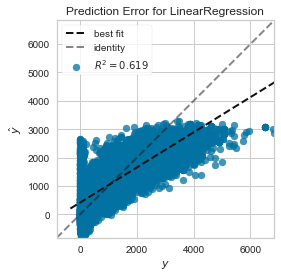

In [7]:
eval_base_score = base.score(x_eval, y_eval)

y_pred_eval_base = base.predict(x_eval)
eval_base_mse = mean_squared_error(y_pred_eval_base, y_eval)

print("R^2 Score: ", eval_base_score)
print("RMSE: ", np.sqrt(eval_base_mse))

visualizer = PredictionError(base)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_eval, y_eval)  # Evaluate the model on the test data
g = visualizer.poof() 

### Random Forrest Regressor 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### Training

In [8]:
rfg = RandomForestRegressor(n_estimators=350, criterion='mse', max_features="log2", bootstrap=True, random_state=42,
                           n_jobs=4)

In [9]:
mean_score = 0
mean_rmse = 0

for train_index, test_index in kf.split(train_dates):
    rfg.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += rfg.score(x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"])
    
    y_pred_rfg = rfg.predict(x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_rfg, 
                                            y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8564900794985968
Average RMSE Score:  390.2443038238378


#### Hyperparameter Tuning

In [11]:
rfg = RandomForestRegressor()

n_estimators = [300, 325, 350]
criterion = ["mse"]
max_features = ["log2", "auto", None]
bootstrap = [True]
oob_score = [True, False]

params = {"n_estimators": n_estimators,
         "criterion": criterion,
         "max_features": max_features,
         "bootstrap": bootstrap,
         "oob_score": oob_score}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=rfg, param_distributions=params, n_iter=10, scoring=scores, n_jobs=4, cv=10,
                        random_state=42, refit="r2")

best_model = hyp.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])

In [12]:
print("Best estimator: ", best_model.best_estimator_)
print("Best R2 score: ", best_model.best_score_)

Best estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best R2 score:  0.7750248106640863


#### Test

R^2 Score:  0.8794478276575658
RMSE:  366.85083811701304


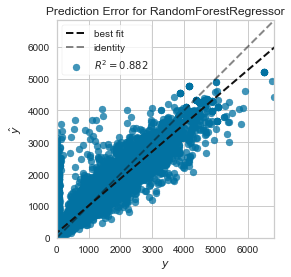

In [10]:
eval_rfg_score = rfg.score(x_eval, y_eval)

y_pred_eval_rfg = rfg.predict(x_eval)
eval_rfg_mse = mean_squared_error(y_pred_eval_rfg, y_eval)

print("R^2 Score: ", eval_rfg_score)
print("RMSE: ", np.sqrt(eval_rfg_mse))

visualizer = PredictionError(rfg)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_eval, y_eval)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save Model

In [14]:
filename = "../../../Data_thesis/Models/rfg_model.sav"

pickle.dump(rfg, open(filename, 'wb'))

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [3]:
xgbr = xgb.XGBRegressor(learning_rate=0.1, n_estimators=275, booster='gbtree', objective='reg:linear',
                       random_state=42, n_jobs=4)

In [7]:
mean_score = 0
mean_rmse = 0

for train_index, test_index in kf.split(train_dates):
    
    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}).values
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"].values
    
    xgbr.fit(x, y)
    
    x_text = x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"}).values
    y_test = y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"].values
    
    mean_score += xgbr.score(x_text,y_test)
    
    y_pred_xgbr = xgbr.predict(x_text)
    mean_rmse += np.sqrt(mean_squared_error(y_pred_xgbr,y_test))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8143045871479682
Average RMSE Score:  445.9703428164218


#### Hyperparameter Tuning

In [13]:
xgbr = xgb.XGBRegressor()

learning_rate = [0.05, 0.1, 0.25, 0.5]
n_estimators = [250, 275, 300]
booster = ["gbtree"]
objective = ["reg:linear", "reg:gamma", "reg:tweedie"]

params = {"learning_rate": learning_rate,
         "n_estimators": n_estimators,
         "booster": booster,
         "objective": objective}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter=10, scoring=scores, n_jobs=2, cv=10,
                        random_state=42, refit="r2")

xgbr_model = hyp.fit(x_train.drop(columns={"Date"}).values, y_train["CrowdednessCount"].values)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [14]:
print("Best estimator: ", xgbr_model.best_estimator_)
print("Best R2 score: ", xgbr_model.best_score_)

Best estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=275, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Best R2 score:  0.7554229501884095


#### Test

R^2 Score:  0.8280708446626357
RMSE:  438.10353758486866


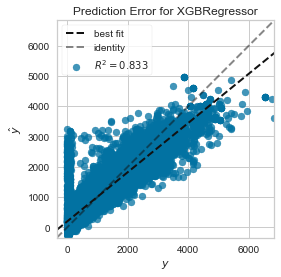

In [8]:
eval_xgbr_score = xgbr.score(x_eval.values, y_eval.values)

y_pred_eval_xgbr = xgbr.predict(x_eval.values)
eval_xgbr_mse = mean_squared_error(y_pred_eval_xgbr, y_eval.values)

print("R^2 Score: ", eval_xgbr_score)
print("RMSE: ", np.sqrt(eval_xgbr_mse))

visualizer = PredictionError(xgbr)
visualizer.fit(x_train.drop(columns={"Date"}).values, y_train["CrowdednessCount"].values) # Fit the training data to the visualizer
visualizer.score(x_eval.values, y_eval.values)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save model to File

In [9]:
filename = "../../../Data_thesis/Models/xgbr_model.sav"

pickle.dump(xgbr, open(filename, 'wb'))